# APS Calculator - Total Cholesterol

## Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import decimal

## Data

In [2]:
veri1 = pd.read_excel('/Users/hikmetcancubukcu/Desktop/18_65_nhanes_na_drop dosyalar/nhanes_20220711_fasting.xlsx')

### Intra-individual Biological Variation of Analyte

In [3]:
# cholesterol CVI value from EFLM
CVI= 5.3
CVI_fraction = CVI/100
# see: https://biologicalvariation.eu/search?query=Cholesterol

### Glycohemoglobin (%) example

### Categorization

In [4]:
# Total Cholesterol (mg/dL) column selection

column_name = 'Total Cholesterol (mg/dL)'
analyte_data = veri1[column_name]

# Numeric HbA1c data to categorical data conversion

bins = [0, 199, 239, np.inf]
names = ['<200', '200-239', '>239']

cat_analyte= pd.cut(analyte_data, bins, labels=names)

cat_analyte_df= pd.DataFrame(cat_analyte)
cat_analyte_df

# concat dfs

cat_analyte_df = cat_analyte_df.rename(columns={column_name: "Analyte_category"})

analyte_last_df = pd.concat([analyte_data, cat_analyte_df],axis = 1)

# Category to number conversion

analyte_last_df['cat_n'] = analyte_last_df['Analyte_category'].replace(
    to_replace=names,
    value=[1, 2, 3], inplace=False)
#analyte_last_df

(76.0, 446.0)

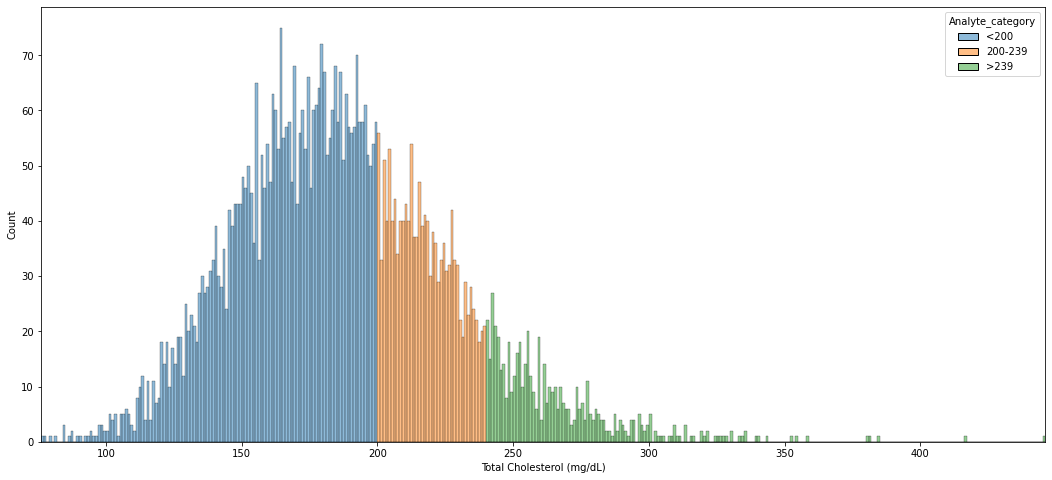

In [5]:
# histogram of original data

import seaborn as sns
import math

plt.figure(figsize=(18, 8))
sns.histplot(data=analyte_last_df, x=column_name, kde=False, hue="Analyte_category",  
              binwidth= 1,discrete= False)

plt.xlim(analyte_last_df[column_name].min(), analyte_last_df[column_name].max())

## Simulation

In [6]:
# Packages

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from numpy import random
from numpy import mean
from sklearn.metrics import precision_recall_fscore_support
import math 

# Selection of original data and original data category

od = analyte_last_df[column_name] # original data
o_cat_n = analyte_last_df['cat_n'] # original data category

### Imprecision with positive bias simulation

In [7]:
# Imprecision with positive bias

nd_list = [] # new data
kappa_score_l = [] # kappa score list
error_l = [] # imprecision list
error_l_b = [] # bias list
error_l_t = [] # total MU

accuracy_score_l = [] # accuracy score list , agreement
sub_accuracy_score_l = [] # sub_accuracy score (sub group accuracy)

n_data = len(od) # sample size
np.random.seed(1923) # seed for reproducible results
imprec_data_raw = np.random.normal(0, 1, n_data)
imprec_data_raw = pd.Series(imprec_data_raw)

# positive error simulation


for e in np.arange(0,0.5,0.01): # CV constant
    for f in np.arange(0,0.5,0.01): # bias constant
        
        n_cat_n = []
        o_cat_n = list(o_cat_n)   
        
        e_CVI=(e**2+CVI_fraction**2)**0.5 # random error + CVI
        
        y_od = od + od*imprec_data_raw*e_CVI  # random error + CVI applied
        nd = y_od + od*f # new data, bias applied
        
        nd_cat= pd.cut(nd, bins, labels=names) # Categorization of the new data
        nd_cat_n = nd_cat.replace(to_replace=names,
        value=[1, 2, 3], inplace=False)
        n_cat_n.append(nd_cat_n)
        n_cat_n = [item for sublist in n_cat_n for item in sublist]
        
        n_cat_n = pd.Series(n_cat_n)
        n_cat_n = n_cat_n.fillna(1)
               
        kappa_score = cohen_kappa_score(o_cat_n, n_cat_n) # Kappa score
        kappa_score_l.append(kappa_score)
        error_l.append(e) # Random error rate save
        error_l_b.append(f) # bias rate save
        accuracy = accuracy_score(o_cat_n, n_cat_n) # Accuracy (Overall Agreement)
        accuracy_score_l.append(accuracy) # accuracy save
        matrix = confusion_matrix(o_cat_n, n_cat_n) # Subclass Accuracy
        matrix_2 = matrix.diagonal()/matrix.sum(axis=1)
        sub_accuracy_score_l.append(matrix_2) # Subclass Accuracy save
        
# sub_accuracy score data frame
sub_accuracy_df = pd.DataFrame(sub_accuracy_score_l)
sub_accuracy_df.columns = names

# list to series conversion
error_l = pd.Series(error_l) 
error_l_b = pd.Series(error_l_b)

kappa_score_l = pd.Series(kappa_score_l)
accuracy_score_l = pd.Series(accuracy_score_l)

# tables comprised of all data
error_kappa_table = pd.concat([error_l, error_l_b,kappa_score_l,accuracy_score_l], axis = 1)
error_kappa_table.columns = ["Imprecision", "Bias",  "Kappa Score", "Accuracy (Agreement)"]
error_kappa_table_1 = pd.concat([error_kappa_table, sub_accuracy_df], axis = 1)

        

### Imprecision with negative bias simulation

In [8]:
# Imprecision with negative bias

nd_list = [] # new data
kappa_score_l = [] # kappa score list
error_l = [] # imprecision list
error_l_b = [] # bias list
error_l_t = [] # total MU

accuracy_score_l = [] # accuracy score list , agreement
sub_accuracy_score_l = [] # sub_accuracy score (sub group accuracy)

n_data = len(od)
np.random.seed(1923) # seed for reproducible results
imprec_data_raw = np.random.normal(0, 1, n_data)
imprec_data_raw = pd.Series(imprec_data_raw)

# negative error simulation


for e in np.arange(0,0.5,0.01): # CV constant
    for f in np.arange(0,0.5,0.01): # bias constant
        
        n_cat_n = []
        o_cat_n = list(o_cat_n)
        
        e_CVI=(e**2+CVI_fraction**2)**0.5 # random error + CVI
        
        y_od = od + od*imprec_data_raw*e_CVI  # random error + CVI applied
        nd = y_od - od*f # new data, bias applied
        
        nd_cat= pd.cut(nd, bins, labels=names) # Categorization of the new data
        nd_cat_n = nd_cat.replace(to_replace=names,
        value=[1, 2, 3], inplace=False)
        n_cat_n.append(nd_cat_n)
        n_cat_n = [item for sublist in n_cat_n for item in sublist]
        
        n_cat_n = pd.Series(n_cat_n)
        n_cat_n = n_cat_n.fillna(1)
        
        kappa_score = cohen_kappa_score(o_cat_n, n_cat_n) # Kappa score
        kappa_score_l.append(kappa_score)
        error_l.append(e) # Random error rate save
        error_l_b.append(-f) # bias rate save
        accuracy = accuracy_score(o_cat_n, n_cat_n) # Accuracy (Overall Agreement)
        accuracy_score_l.append(accuracy) # accuracy save
        matrix = confusion_matrix(o_cat_n, n_cat_n) # Subclass Accuracy
        matrix_2 = matrix.diagonal()/matrix.sum(axis=1)
        sub_accuracy_score_l.append(matrix_2) # Subclass Accuracy save
        
# sub_accuracy score data frame
sub_accuracy_df = pd.DataFrame(sub_accuracy_score_l)
sub_accuracy_df.columns = names

# list to series conversion
error_l = pd.Series(error_l) 
error_l_b = pd.Series(error_l_b)

kappa_score_l = pd.Series(kappa_score_l)
accuracy_score_l = pd.Series(accuracy_score_l)

# tables comprised of all data
error_kappa_table = pd.concat([error_l, error_l_b, kappa_score_l,accuracy_score_l], axis = 1)
error_kappa_table.columns = ["Imprecision", "Bias",  "Kappa Score", "Accuracy (Agreement)"]
error_kappa_table_1_1 = pd.concat([error_kappa_table, sub_accuracy_df], axis = 1)
error_kappa_table_2 = pd.concat([error_kappa_table_1, error_kappa_table_1_1], axis = 0) # concat positive and negative error simulation data



In [9]:
# Concat positive and negative bias simulation data

error_kappa_table_2 = pd.concat([error_kappa_table_1, error_kappa_table_1_1], axis = 0) # concat positive and negative error simulation data
error_kappa_table_2 = error_kappa_table_2.reset_index() # reset index


## Kappa score categorization

In [10]:
# Kappa score categorization

bins_k = [0, 0.599999999, 0.799999999, 0.9, np.inf]
names_k = ['0-.59','.60-.79', '.80-.90', '>.90']

cat_kappa= pd.cut(error_kappa_table_2['Kappa Score'], bins_k, labels=names_k)

cat_kappa_df= pd.DataFrame(cat_kappa)
cat_kappa_df

# concat dfs

cat_kappa_df = cat_kappa_df.rename(columns={"Kappa Score": "Kappa Category"})

# Outcome full
error_kappa_table_2_v2 = pd.concat([error_kappa_table_2, cat_kappa_df],axis = 1)


# Outcome corresponding Allowable APS

error_kappa_table_3 = error_kappa_table_2_v2[error_kappa_table_2_v2['Kappa Score']>=0.60]


# Visiualisation of Data

## Kappa Score vs Imprecision & Bias
### 3d Scattter Plot

<class 'matplotlib.axes._subplots.Axes3DSubplot'>


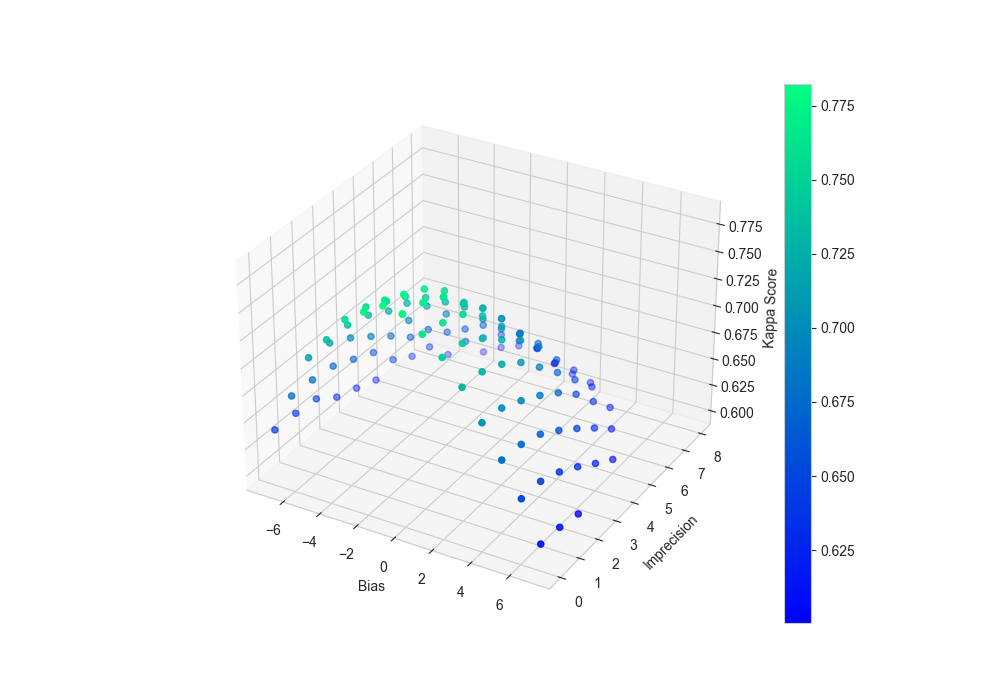

In [11]:
# 3d Scattter Plot

import ipympl
%matplotlib widget
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_style('whitegrid')
plt.figure(figsize=(10,7))

axes = plt.axes(projection='3d')

color_map = plt.get_cmap('winter')


print(type(axes))
x1 = error_kappa_table_3['Bias']*100 # percentage unit
y1 = error_kappa_table_3['Imprecision']*100 # percentage unit
z1 = error_kappa_table_3['Kappa Score']

scatter_plot= axes.scatter3D(x1, y1, z1, c=(z1),
                            cmap = color_map
                            )

axes.set_xlabel('Bias')
axes.set_ylabel('Imprecision')
axes.set_zlabel('Kappa Score')

axes.view_init()

plt.colorbar(scatter_plot)

plt.show()

## Kappa Category Contour Plot

(0.0, 10.0)

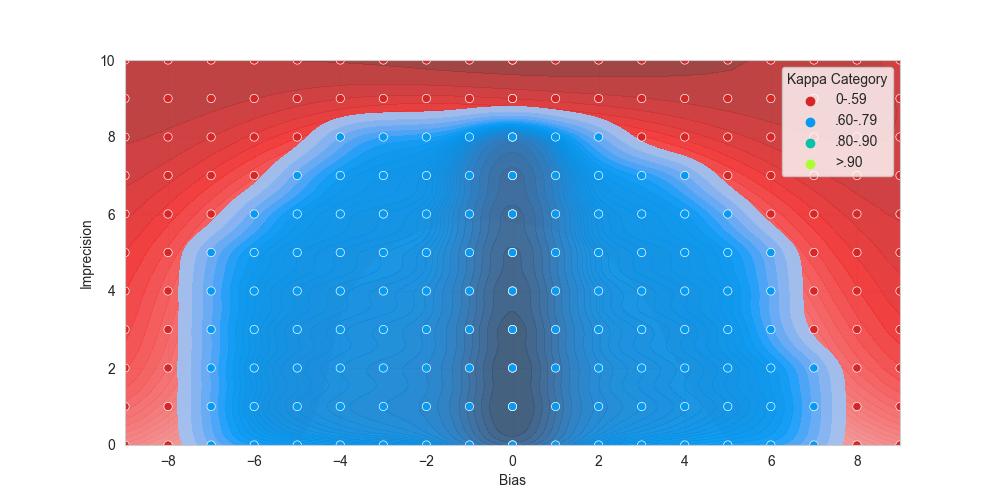

In [12]:
# percentage unit conversion by multiplying 100
error_kappa_table_2_v3 = error_kappa_table_2_v2[['Imprecision','Bias','Accuracy (Agreement)']].apply(lambda x: x*100) # percentage unit conversion
error_kappa_table_2_v3 = pd.concat([error_kappa_table_2_v3, error_kappa_table_2_v2[['Kappa Category','Kappa Score']]], axis = 1) # concat 

                                              
# contour plot
import matplotlib.colors as mcolors

plt.figure(figsize=(10, 5))
palette = ['tab:red', 'xkcd:azure', 'xkcd:turquoise', 'xkcd:lime']
palette2 = ['tab:red', 'xkcd:azure', 'xkcd:turquoise', 'xkcd:lime']
sns.kdeplot(data=error_kappa_table_2_v3, x="Bias",y = "Imprecision",hue = 'Kappa Category', fill=True
            ,palette=palette, common_norm=False,levels=30, alpha=0.95,warn_singular=False, bw_adjust=0.5
            ,bw_method='scott',weights='Kappa Score')
sns.scatterplot(data=error_kappa_table_2_v3, x="Bias",y = "Imprecision", hue = 'Kappa Category' ,palette=palette2)


error_kappa_table_3_v3 = error_kappa_table_2_v3[error_kappa_table_2_v3['Kappa Score']>=0.60] # for x and y axis limit adjustment 
limit_xn = error_kappa_table_3_v3['Bias'].min()
limit_xp = error_kappa_table_3_v3['Bias'].max()
ylim_v1 = error_kappa_table_3_v3['Imprecision'].max()

plt.xlim(limit_xn-2, limit_xp +2)
plt.ylim(0, ylim_v1+2)

In [13]:
# APS for İmprecision, Bias

# APS levels allocation based on Kappa value
error_kappa_table_3 = error_kappa_table_2_v2[(error_kappa_table_2_v2['Kappa Score']>=0.60) & (error_kappa_table_2_v2['Kappa Score']<0.80)]
error_kappa_table_4 = error_kappa_table_2_v2[(error_kappa_table_2_v2['Kappa Score']>=0.8) & (error_kappa_table_2_v2['Kappa Score']<0.9)]
error_kappa_table_5 = error_kappa_table_2_v2[error_kappa_table_2_v2['Kappa Score']>0.9]

# generation of dataframe
data_aps = {'APS level': ['Minimum', 'Desirable', 'Optimum'],
        'Imprecision': [error_kappa_table_3['Imprecision'].max(), error_kappa_table_4['Imprecision'].max(), error_kappa_table_5['Imprecision'].max()],
       'Positive Bias': [error_kappa_table_3['Bias'].max(), error_kappa_table_4['Bias'].max(), error_kappa_table_5['Bias'].max()],
       'Negative Bias': [error_kappa_table_3['Bias'].min(), error_kappa_table_4['Bias'].min(), error_kappa_table_5['Bias'].min()],
        'Minimum Accuracy (Agreement)': [error_kappa_table_3['Accuracy (Agreement)'].min(), error_kappa_table_4['Accuracy (Agreement)'].min(), error_kappa_table_5['Accuracy (Agreement)'].min()],
           'Maximum Accuracy (Agreement)': [error_kappa_table_3['Accuracy (Agreement)'].max(), error_kappa_table_4['Accuracy (Agreement)'].max(), error_kappa_table_5['Accuracy (Agreement)'].max()]}
data_aps = pd.DataFrame(data_aps)

data_aps.loc[data_aps['Positive Bias'] < 0, 'Positive Bias'] = 0 # replace values are not found > 0 with 0

data_aps_v2= data_aps[['Imprecision','Positive Bias','Negative Bias','Minimum Accuracy (Agreement)', 'Maximum Accuracy (Agreement)']]*100

# APS level as first column 
data_aps_v2['APS level'] = ['Minimum (%)', 'Desirable (%)', 'Optimum (%)']
first_column = data_aps_v2.pop('APS level') 
data_aps_v2.insert(0, 'APS level', first_column)


data_aps_v2.iloc[:1,:4]


,APS level,Imprecision,Positive Bias,Negative Bias
0,Minimum (%),8.0,7.0,-7.0


# 

# ---------------------------------------------------------------------------------------
# End of APS Calculation
# ---------------------------------------------------------------------------------------